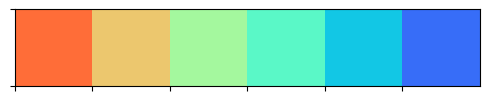

In [11]:
import os, warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['CUDA_VISIBLE_DEVICES'] = '7'

import tensorflow as tf
import gc
import tensorflow.keras.backend as K

gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

import pandas as pd
from pandas import Series
import numpy as np
from joblib import Parallel, delayed
from tqdm.auto import tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
import molmap.model

import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette("rainbow_r", 6) #PiYG
sns.palplot(color)

from joblib import load, dump
import sklearn.metrics
import scipy
import logging

def r2_score(y_true,y_pred):
    y_mean = np.mean(y_true)
    r2 = 1-sum((y_true-y_pred)**2)/sum((y_mean-y_true)**2)
    return r2
def PCC(y_pred,y_true):
    diff_pred,diff_true=y_pred-np.mean(y_pred),y_true-np.mean(y_true)
    return np.sum(diff_pred*diff_true)/np.sqrt(np.sum(diff_pred**2)*np.sum(diff_true**2))

def from_ic50(ic50, max_ic50=50000.0):
    x = 1.0 - (np.log(np.maximum(ic50, 1e-12)) / np.log(max_ic50))
    return np.minimum(
        1.0,
        np.maximum(0.0, x))
def to_ic50(x, max_ic50=50000.0):
    return max_ic50 ** (1.0 - x)
sample_weight=None,
threshold_nm=500,
max_ic50=50000

获得三维特征

In [2]:
# 载入氨基酸替换矩阵
blosum62 = pd.read_csv('/mnt/zt/Dopaap/dopaap_predictor/blosum_pam_data/BLOSUM62.txt', sep='\s')
blosum62 = blosum62.iloc[:-4,:-4]

pam250 = pd.read_csv('/mnt/zt/Dopaap/dopaap_predictor/blosum_pam_data/PAM250.csv',index_col=0)
# pam250

# aapro归一化
PCP = pd.read_csv('/mnt/zt/Dopaap/dopaap_predictor/cal_CTD/PCP_61.csv', index_col='properties').index
AApro_dic = pd.read_csv('/mnt/zt/Dopaap/dopaap_predictor/umap/single_index/AApro_UMAP.csv', header=0,index_col=0)
AA_pro = AApro_dic.loc[PCP].astype('float')
AA_pro = AA_pro.T
AA_pro = ((AA_pro - AA_pro.min()) / (AA_pro.max() - AA_pro.min())).T #归一化

# 生成三维特征图
def get_3d_feat(seq):
    n = len(seq)

    # 生成理化性质矩阵
    seq_pro = pd.DataFrame(AA_pro[aa] for aa in seq).T
    seq_pro = seq_pro.values[:, :, None]  #二维变成三维（61， n， 1）
    ## 相乘
    mt_pro = np.transpose((seq_pro * np.transpose(seq_pro, [0, 2, 1])), [1, 2, 0])  #**.5   #here!! **0.25
    ## transpose三维转置。（61，n，1）*（61，1，n）=（61，n，n），再转置成（n，n，61）.

    # 生成blosum矩阵
    seq_blosum = np.ones((n,n))
    for i in range(n):
        a = seq[i]
        for j in range(n):
            b = seq[j]
            seq_blosum[i][j] = blosum62.loc[a,b]
    seq_blosum_nor = ((seq_blosum - seq_blosum.min()) / (seq_blosum.max() - seq_blosum.min()))
    seq_blosum_nor = seq_blosum_nor[:, :, np.newaxis]  ##（n，n，1）

    # 生成pam矩阵
    seq_pam = np.ones((n,n))
    for i in range(n):
        a = seq[i]
        for j in range(n):
            b = seq[j]
            seq_pam[i][j] = pam250.loc[a,b]
    seq_pam_nor = ((seq_pam - seq_pam.min()) / (seq_pam.max() - seq_pam.min()))
    seq_pam_nor = seq_pam_nor[:, :, np.newaxis]  ##（n，n，1）

    # 生成序列距离矩阵
    pt_dis = np.ones((n,n))
    for i in range(n):
        for j in range(n):
            pt_dis[i][j] = abs(i-j)
    pt_dis = ((pt_dis - 0) / (n-1 - 0)) ## 归一化（最小值为0，最大值为n-1）
    pt_dis = pt_dis[:, :, np.newaxis]  ##（n，n，1）

    # 改变 理化性质矩阵 的下半部分
    for k in range(mt_pro.shape[2]):
        for i in range(n):
            for j in range(i):
                if k < 60:                                      ##here
                    mt_pro[i,j,k] = (mt_pro[j,i,k] * mt_pro[j,i,k+1])**.5
                else:
                    mt_pro[i,j,k] = (mt_pro[j,i,k] * mt_pro[j,i,0])**.5

    # 将序列距离矩阵与mt合并，并放在第一层
    mt = np.concatenate((pt_dis,seq_blosum_nor,seq_pam_nor,mt_pro),axis = 2)

    x = np.pad(mt, [(0, max_seq_len-n), (0, max_seq_len-n), (0, 0)]) #填充0.令数据集中每条序列对应的Xshape相同。

    return x[ :, :, :, None]

模型细节

In [3]:
class Inception(tf.keras.layers.Layer):

    def __init__(self, units = 8, strides = 1):
        super(Inception, self).__init__()
        self.conv1 = tf.keras.layers.Conv3D(units, (1,1,1), padding='same', activation = 'relu', strides = strides,kernel_regularizer=tf.keras.regularizers.l2(lamda))
        self.conv2 = tf.keras.layers.Conv3D(units, (3,3,3), padding='same', activation = 'relu', strides = strides,kernel_regularizer=tf.keras.regularizers.l2(lamda))
        self.conv3 = tf.keras.layers.Conv3D(units, (5,5,5), padding='same', activation = 'relu', strides = strides,kernel_regularizer=tf.keras.regularizers.l2(lamda))
        self.concat = tf.keras.layers.Concatenate()

    def call(self, inputs):
        x1 = self.conv1(inputs)
        x2 = self.conv2(inputs)
        x3 = self.conv3(inputs)
        outputs = self.concat([x1, x2, x3])
        return outputs

    def get_config(self): 
        config = {"conv1": self.conv1,"conv2":self.conv2,'conv3':self.conv3}
        base_config = super(Inception, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


In [4]:
class Model_1(tf.keras.Model):
    def __init__(self):
            super().__init__()
            
            self.Cov_1 = tf.keras.layers.Conv3D(kn_1, ks_fir, activation='relu', padding='same',kernel_regularizer=tf.keras.regularizers.l2(lamda))
            self.MaxPool_1 = tf.keras.layers.MaxPool3D() #pool_size = (2,2,2)
    #         #here
    #         tf.keras.layers.Conv3D(kn_1, (5,5,5), activation='relu', padding='same',kernel_regularizer=tf.keras.regularizers.l2(lamda),
    # bias_regularizer=tf.keras.regularizers.l1(lamda), activity_regularizer=tf.keras.regularizers.l2(lamda)),
    #         tf.keras.layers.MaxPool3D(), #pool_size = (2,2,2)
    #         #here
            self.Cov_2 =Inception(units=kn_2, strides=1)
            self.MaxPool_2 = tf.keras.layers.MaxPool3D()
            self.Cov_3 = Inception(units=kn_3, strides=1)
            self.GlobalMaxPool = tf.keras.layers.GlobalMaxPooling3D()         #tf.keras.layers.Flatten(),
            self.Dense_1 = tf.keras.layers.Dense(128, activation='relu')
            self.Dense_2 =tf.keras.layers.Dense(32, activation='relu')
            self.Dense_3 =tf.keras.layers.Dense(1)
    
    def call(self, input):
            x = self.Cov_1(input)
            x = self.MaxPool_1(x)
            x = self.Cov_2(x) 
            x = self.MaxPool_2(x)
            x = self.Cov_3(x)
            x = self.GlobalMaxPool(x)
            x = self.Dense_1(x)
            x = self.Dense_2(x)
            x = self.Dense_3(x)
            return x

In [5]:
class Model_2(tf.keras.Model):
    def __init__(self):
            super().__init__()
            
            self.Cov_1 = tf.keras.layers.Conv3D(kn_1, ks_fir, activation='relu', padding='same',kernel_regularizer=tf.keras.regularizers.l2(lamda))
            self.MaxPool_1 = tf.keras.layers.MaxPool3D() #pool_size = (2,2,2)
    #         #here
    #         tf.keras.layers.Conv3D(kn_1, (5,5,5), activation='relu', padding='same',kernel_regularizer=tf.keras.regularizers.l2(lamda),
    # bias_regularizer=tf.keras.regularizers.l1(lamda), activity_regularizer=tf.keras.regularizers.l2(lamda)),
    #         tf.keras.layers.MaxPool3D(), #pool_size = (2,2,2)
    #         #here
            self.Cov_2 =Inception(units=kn_2, strides=1)
            self.MaxPool_2 = tf.keras.layers.MaxPool3D()
            self.Cov_3 = Inception(units=kn_3, strides=1)
            self.GlobalMaxPool = tf.keras.layers.GlobalMaxPooling3D()         #tf.keras.layers.Flatten(),
            self.Dense_1 = tf.keras.layers.Dense(512, activation='relu')
            self.Dense_2 =tf.keras.layers.Dense(64, activation='relu')
            self.Dense_3 =tf.keras.layers.Dense(1)
            
    
    def call(self, input):
            x = self.Cov_1(input)
            x = self.MaxPool_1(x)
            x = self.Cov_2(x) 
            x = self.MaxPool_2(x)
            x = self.Cov_3(x)
            x = self.GlobalMaxPool(x)
            x = self.Dense_1(x)
            x = self.Dense_2(x)
            x = self.Dense_3(x)
            return x

In [6]:
class Model_3(tf.keras.Model):
    def __init__(self):
            super().__init__()
            
            self.Cov_1 = tf.keras.layers.Conv3D(kn_1, ks_fir, activation='relu', padding='same',kernel_regularizer=tf.keras.regularizers.l2(lamda))
            self.MaxPool_1 = tf.keras.layers.MaxPool3D() #pool_size = (2,2,2)
    #         #here
    #         tf.keras.layers.Conv3D(kn_1, (5,5,5), activation='relu', padding='same',kernel_regularizer=tf.keras.regularizers.l2(lamda),
    # bias_regularizer=tf.keras.regularizers.l1(lamda), activity_regularizer=tf.keras.regularizers.l2(lamda)),
    #         tf.keras.layers.MaxPool3D(), #pool_size = (2,2,2)
    #         #here
            self.Cov_2 =Inception(units=kn_2, strides=1)
            # self.MaxPool_2 = tf.keras.layers.MaxPool3D()
            # self.Cov_3 = Inception(units=kn_3, strides=1)
            self.GlobalMaxPool = tf.keras.layers.GlobalMaxPooling3D()         #tf.keras.layers.Flatten(),
            self.Dense_1 = tf.keras.layers.Dense(512, activation='relu')
            self.Dense_2 =tf.keras.layers.Dense(64, activation='relu')
            self.Dense_3 =tf.keras.layers.Dense(1)
            
    
    def call(self, input):
            x = self.Cov_1(input)
            x = self.MaxPool_1(x)
            x = self.Cov_2(x) 
            # x = self.MaxPool_2(x)
            # x = self.Cov_3(x)
            x = self.GlobalMaxPool(x)
            x = self.Dense_1(x)
            x = self.Dense_2(x)
            x = self.Dense_3(x)
            return x

In [7]:
class Model_4(tf.keras.Model):
    def __init__(self):
            super().__init__()
            
            self.Cov_1 = tf.keras.layers.Conv3D(kn_1, ks_fir, activation='relu', padding='same',kernel_regularizer=tf.keras.regularizers.l2(lamda))
            self.MaxPool_1 = tf.keras.layers.MaxPool3D() #pool_size = (2,2,2)
            self.Cov_2 =Inception(units=kn_2, strides=1)
            self.GlobalMaxPool = tf.keras.layers.GlobalMaxPooling3D()         #tf.keras.layers.Flatten(),
            self.Dense_1 = tf.keras.layers.Dense(128, activation='relu')
            self.Dense_2 =tf.keras.layers.Dense(32, activation='relu')
            self.Dense_3 =tf.keras.layers.Dense(1)
    
    def call(self, input):
            x = self.Cov_1(input)
            x = self.MaxPool_1(x)
            x = self.Cov_2(x) 
            x = self.GlobalMaxPool(x)
            x = self.Dense_1(x)
            x = self.Dense_2(x)
            x = self.Dense_3(x)
            return x

In [8]:
class Model_5(tf.keras.Model):
    def __init__(self):
            super().__init__()
            
            self.Cov_1 = tf.keras.layers.Conv3D(kn_1, ks_fir, activation='relu', padding='same',kernel_regularizer=tf.keras.regularizers.l2(lamda))
            self.MaxPool_1 = tf.keras.layers.MaxPool3D() #pool_size = (2,2,2)
            #here
            self.Cov_2 = tf.keras.layers.Conv3D(kn_1, (5,5,5), activation='relu', padding='same',kernel_regularizer=tf.keras.regularizers.l2(lamda))
            self.MaxPool_2 = tf.keras.layers.MaxPool3D() #pool_size = (2,2,2)
            #here
            self.Cov_3 =Inception(units=kn_2, strides=1)
            self.MaxPool_3 = tf.keras.layers.MaxPool3D()
            self.Cov_4 = Inception(units=kn_3, strides=1)
            self.GlobalMaxPool = tf.keras.layers.GlobalMaxPooling3D()         #tf.keras.layers.Flatten(),
            self.Dense_1 = tf.keras.layers.Dense(128, activation='relu')
            self.Dense_2 =tf.keras.layers.Dense(32, activation='relu')
            self.Dense_3 =tf.keras.layers.Dense(1)
            
    
    def call(self, input):
            x = self.Cov_1(input)
            x = self.MaxPool_1(x)
            #here
            x = self.Cov_2(x)
            x = self.MaxPool_2(x)
            #here
            x = self.Cov_3(x) 
            x = self.MaxPool_3(x)
            x = self.Cov_4(x)
            x = self.GlobalMaxPool(x)
            x = self.Dense_1(x)
            x = self.Dense_2(x)
            x = self.Dense_3(x)
            return x

In [9]:
class Model_6(tf.keras.Model):
    def __init__(self):
            super().__init__()
            
            self.Cov_1 = tf.keras.layers.Conv3D(kn_1, ks_fir, activation='relu', padding='same',kernel_regularizer=tf.keras.regularizers.l2(lamda))
            self.MaxPool_1 = tf.keras.layers.MaxPool3D() #pool_size = (2,2,2)
    #         #here
    #         tf.keras.layers.Conv3D(kn_1, (5,5,5), activation='relu', padding='same',kernel_regularizer=tf.keras.regularizers.l2(lamda),
    # bias_regularizer=tf.keras.regularizers.l1(lamda), activity_regularizer=tf.keras.regularizers.l2(lamda)),
    #         tf.keras.layers.MaxPool3D(), #pool_size = (2,2,2)
    #         #here
            self.Cov_2 =Inception(units=kn_2, strides=1)
            # self.MaxPool_2 = tf.keras.layers.MaxPool3D()
            # self.Cov_3 = Inception(units=kn_3, strides=1)
            self.GlobalMaxPool = tf.keras.layers.GlobalMaxPooling3D()         #tf.keras.layers.Flatten(),
            self.Dense_1 = tf.keras.layers.Dense(128, activation='relu')
            self.Dense_2 =tf.keras.layers.Dense(32, activation='relu')
            self.Dense_3 =tf.keras.layers.Dense(1)
            
    
    def call(self, input):
            x = self.Cov_1(input)
            x = self.MaxPool_1(x)
            x = self.Cov_2(x) 
            # x = self.MaxPool_2(x)
            # x = self.Cov_3(x)
            x = self.GlobalMaxPool(x)
            x = self.Dense_1(x)
            x = self.Dense_2(x)
            x = self.Dense_3(x)
            return x

In [10]:
class Model_7(tf.keras.Model):
    def __init__(self):
            super().__init__()
            
            self.Cov_1 = tf.keras.layers.Conv3D(kn_1, ks_fir, activation='relu', padding='same',kernel_regularizer=tf.keras.regularizers.l2(lamda))
            self.MaxPool_1 = tf.keras.layers.MaxPool3D() #pool_size = (2,2,2)
    #         #here
    #         tf.keras.layers.Conv3D(kn_1, (5,5,5), activation='relu', padding='same',kernel_regularizer=tf.keras.regularizers.l2(lamda),
    # bias_regularizer=tf.keras.regularizers.l1(lamda), activity_regularizer=tf.keras.regularizers.l2(lamda)),
    #         tf.keras.layers.MaxPool3D(), #pool_size = (2,2,2)
    #         #here
            self.Cov_2 =Inception(units=kn_2, strides=1)
            self.MaxPool_2 = tf.keras.layers.MaxPool3D()
            self.Cov_3 = Inception(units=kn_3, strides=1)
            self.GlobalMaxPool = tf.keras.layers.GlobalMaxPooling3D()         #tf.keras.layers.Flatten(),
            self.Dense_1 = tf.keras.layers.Dense(64, activation='relu')
            self.Dense_2 =tf.keras.layers.Dense(16, activation='relu')
            self.Dense_3 =tf.keras.layers.Dense(1)
    
    def call(self, input):
            x = self.Cov_1(input)
            x = self.MaxPool_1(x)
            x = self.Cov_2(x) 
            x = self.MaxPool_2(x)
            x = self.Cov_3(x)
            x = self.GlobalMaxPool(x)
            x = self.Dense_1(x)
            x = self.Dense_2(x)
            x = self.Dense_3(x)
            return x

自动化预测

In [31]:
test_dir = '/mnt/zt/Dopaap/calculate_webtools_score/new_released/iedb_tools_predict_data_processed'
loss_models_results_dir = '/mnt/zt/Dopaap/dopaap_predictor/loss_models_results'

allele_list = [allele for allele in os.listdir(test_dir) if allele in os.listdir(loss_models_results_dir)]

for allele in allele_list:
    df_test = pd.read_csv(os.path.join(test_dir, allele, 'tools_processed.csv'))
    max_seq_len = df_test['Description_Length'].max()

    # 生成 X_test + Y_test 
    X_dir= '/mnt/zt/Dopaap/dopaap_predictor/middle_data/new_released_X_test_data'
    X_test_name = os.path.join(X_dir, allele+'_X_test'+'.data')
    if not os.path.exists(X_test_name) :
        X_test = []
        for seq in df_test['Description']:
            X_test.append(get_3d_feat(seq))
        X_test = np.stack(X_test)
        dump(X_test, X_test_name)
    else:
        X_test = load(X_test_name)
    X_test = X_test.astype('float32') 

    # 载入模型和参数
    model_dir = os.path.join(loss_models_results_dir, allele,'models')
    df_res = pd.read_csv('/mnt/zt/Dopaap/dopaap_predictor/pred_true/results_noMS_1.csv',index_col=0)
    #上述csv文件HLA-a0101 model为空 手动补入了model1
    # hla-a2402 model1会报错 手动改成了model2
    
    # 參數
    lr = df_res['lr'][allele]
    ks_fir = df_res['kernel_size_1'][allele]
    ks_fir = eval(ks_fir)
    kn = df_res['kernel_number'][allele]
    kn = eval(kn)
    kn_1,kn_2,kn_3 = kn[0],kn[1],kn[2]
    lamda = df_res['lamda'][allele]
    md = df_res['model'][allele]

    model_index = md.split('_')[1]
    model = eval('Model_' + model_index+'()')

    X = load(X_test_name)
    model.build(X.shape)
    model.load_weights(os.path.join(model_dir,allele+'_noMS_model_.h5'))

    print(
    allele,
    'lr=',lr,
    'ks_fir=',ks_fir,
    'kn=',kn,
    'lamda=',lamda,
    'model=',md
    )

    # 做出预测
    Y_pred = model.predict(X_test)
    df_pred = pd.DataFrame(Y_pred).rename(columns={0:'Dopaap_IC50_Normalized'})
    df_combined = pd.concat([df_test, df_pred], axis=1)
    df_combined.to_csv(os.path.join(test_dir, allele, 'tools_processed.csv'), index=False)

HLA-A_0201 lr= 0.0001 ks_fir= (9, 9, 13) kn= (48, 32, 64) lamda= 1e-06 model= Model_5
6/6 [==============================] - 0s 9ms/step
HLA-A_0301 lr= 0.0001 ks_fir= (3, 3, 27) kn= (48, 32, 64) lamda= 0.0001 model= Model_2
4/4 [==============================] - 0s 4ms/step
HLA-A_0101 lr= 0.0001 ks_fir= (9, 9, 13) kn= (48, 32, 64) lamda= 0.001 model= Model_1 
2/2 [==============================] - 0s 6ms/step
HLA-A_1101 lr= 0.0001 ks_fir= (9, 9, 13) kn= (48, 32, 64) lamda= 1e-09 model= Model_1 
2/2 [==============================] - 0s 16ms/step
HLA-A_2402 lr= 0.0001 ks_fir= (3, 3, 7) kn= (24, 16, 32) lamda= 1e-05 model= Model_2  
3/3 [==============================] - 0s 4ms/step
HLA-B_0702 lr= 0.0001 ks_fir= (3, 3, 7) kn= (48, 32, 64) lamda= 1e-09 model= Model_1 
2/2 [==============================] - 0s 7ms/step
HLA-B_1501 lr= 0.0001 ks_fir= (3, 3, 27) kn= (48, 32, 64) lamda= 1e-06 model= Model_1 
1/1 [==============================] - 0s 212ms/step
HLA-B_2705 lr= 0.0001 ks_fir= (3,

拼接测试集预测结果，并计算准确率

In [40]:
pred_dir = '/raid/hly/PK-3[2018PLOS]/new_arraylist_task/test_set/vaccin_model/test_predtrue/split_by_Allele'
df_allpred = pd.DataFrame()
for file in os.listdir(pred_dir):
    Allele = file.split('_')[0] + '_' + file.split('_')[1]
    pred_file = pd.read_csv(os.path.join(pred_dir,file),index_col=0)
    pred_file['Allele'] = Allele 
    df_allpred = df_allpred.append(pred_file)
    # df_allpred['Pred_Norm_QM_NetMHCpan4.0(nM)'] = df_allpred['Pred_QM_NetMHCpan4.0(nM)'].apply(from_ic50)
df_allpred.to_csv('/raid/hly/PK-3[2018PLOS]/new_arraylist_task/test_set/vaccin_model/test_predtrue/test_predtrue.csv',index=0)

In [41]:
df_allpred = pd.read_csv('/raid/hly/PK-3[2018PLOS]/new_arraylist_task/test_set/vaccin_model/test_predtrue/test_predtrue.csv')
df_allpred.head()

,Allele,Allele Name,Assay Group,Host Name,MHC allele class,Measurement Inequality,Normalized_QM,Pred_Norm_QM_Dopaap(nM),Pred_QM_Dopaap(nM),Qualitative Measure,...,Unnamed: 0.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1,measurement_value,peptide
0,HLA-A_1101,HLA-A*11:01,half maximal inhibitory concentration (IC50),Homo sapiens (human),I,=,0.110472,0.242901,3610.648599,Negative,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15131.0,EKVKIPVAIKT
1,HLA-A_1101,HLA-A*11:01,half maximal inhibitory concentration (IC50),Homo sapiens (human),I,=,0.146594,0.268877,2725.987047,Negative,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10236.0,KVKIPVAIKT
2,HLA-A_1101,HLA-A*11:01,half maximal inhibitory concentration (IC50),Homo sapiens (human),I,=,0.136599,0.269744,2700.555449,Negative,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11405.0,KVKIPVAIKTS
3,HLA-A_1101,HLA-A*11:01,half maximal inhibitory concentration (IC50),Homo sapiens (human),I,=,0.375287,0.246987,3454.507975,Positive-Intermediate,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,862.0,KIPVAIKTSPK
4,HLA-A_1101,HLA-A*11:01,half maximal inhibitory concentration (IC50),Homo sapiens (human),I,=,0.249798,0.209436,5186.035377,Positive-Intermediate,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3351.0,IPVAIKTSPK


In [42]:
# y_OD = df_allpred['measurement_value(O.D)'].to_list()
# y_pred_D = df_allpred['Pred_Norm_QM_Dopaap(nM)'].to_list()
# y_pred_N = df_allpred['Pred_Norm_QM_NetMHCpan4.0(nM)'].to_list()


In [43]:
y_OD = df_allpred['Normalized_QM'].to_list()
y_pred_D = df_allpred['Pred_Norm_QM_Dopaap(nM)'].to_list()
# y_pred_N = df_allpred['Pred_QM_NetMHCpan4.0(nM)'].to_list()

In [44]:
# 计算R2
from sklearn.metrics import r2_score
import pandas as pd
r2_D = r2_score(y_OD, y_pred_D)
# r2_N = r2_score(y_OD, y_pred_N)
# print('r2_Dopaap = ',r2_D,'r2_NetMHCpan4.0 = ',r2_N)
print('r2_Dopaap = ',r2_D)


r2_Dopaap =  -0.4784516745608651


In [45]:
# 计算 Pearson r
def PCC(y_pred,y_true):
    diff_pred,diff_true=y_pred-np.mean(y_pred),y_true-np.mean(y_true)
    return np.sum(diff_pred*diff_true)/np.sqrt(np.sum(diff_pred**2)*np.sum(diff_true**2))
PCC_D = PCC(y_OD, y_pred_D)
# PCC_N = PCC(y_OD, y_pred_N)
# print('PCC_Dopaap = ',PCC_D,'PCC_NetMHCpan4.0 = ',PCC_N)
print('PCC_Dopaap = ',PCC_D)


PCC_Dopaap =  0.09355308563555101


In [46]:
# 计算 tau
import scipy.stats
tau_D = scipy.stats.kendalltau(y_pred_D, y_OD)[0]
# tau_N = scipy.stats.kendalltau(y_pred_N, y_OD)[0]
# print('tau_Dopaap = ',tau_D,'tau_NetMHCpan4.0 = ',tau_N)
print('tau_Dopaap = ',tau_D)



tau_Dopaap =  0.09393014006129069


In [47]:
pred_dir = '/raid/hly/PK-3[2018PLOS]/new_arraylist_task/test_set/vaccin_model/test_predtrue/split_by_Allele'
df_allpred = pd.DataFrame()
for file in os.listdir(pred_dir):
    Allele = file.split('_')[0] + '_' + file.split('_')[1]
    pred_file = pd.read_csv(os.path.join(pred_dir,file),index_col=0)
    y_OD = pred_file['Normalized_QM'].to_list()
    y_pred_D = pred_file['Pred_Norm_QM_Dopaap(nM)'].to_list()
    r2_D = r2_score(y_OD, y_pred_D)
    PCC_D = PCC(y_OD, y_pred_D)
    tau_D = scipy.stats.kendalltau(y_pred_D, y_OD)[0]
    print(Allele,'r2=',r2_D,'pcc=',PCC_D,'tau=',tau_D)

HLA-A_1101 r2= -0.02280385663339457 pcc= 0.5173106070846867 tau= 0.32510919583225417
HLA-A_3301 r2= -0.276474391564409 pcc= 0.20609652263563333 tau= -0.3333333333333334
HLA-B_0702 r2= 0.08971414610044748 pcc= 0.6417720918502827 tau= 0.4679943100995733
HLA-B_4403 r2= 0.38692125270725697 pcc= 0.7487711093176592 tau= 0.5
HLA-A_3001 r2= -0.3729696375066267 pcc= 0.786200039475072 tau= 0.6
HLA-B_1501 r2= 0.09971377150883487 pcc= 0.47207976248133976 tau= 0.3368421052631579
HLA-A_0101 r2= 0.1790187094075245 pcc= 0.5222959189417972 tau= 0.2972972972972973
HLA-A_6801 r2= 0.8366438425356468 pcc= 0.9420439357209872 tau= 1.0
HLA-B_2705 r2= -0.8341610991341883 pcc= 0.786756335091254 tau= 0.44928930135864076
HLA-B_5101 r2= -0.07542723054751566 pcc= -0.12942575499665182 tau= -0.33333333333333337
HLA-A_0201 r2= -1.9430003834391183 pcc= 0.16283579828409697 tau= 0.1312398731096655
HLA-B_0801 r2= -2.545531900345918 pcc= 0.6763077623000986 tau= 0.37796447300922725
HLA-A_0301 r2= -0.1908920316706888 pcc= 0.